# Exploring the NHANES diabetes data

[DSLC stages]: EDA


You can conduct an EDA of the NHANES diabetes dataset in this document.

In [58]:
import pandas as pd
import numpy as np

# Load the datasets from CSV files
train_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')
test_data = pd.read_csv('test_data.csv')
ames_data = pd.read_csv('anes_data.csv')
                        
data_States = pd.read_csv('data_States.csv')
data_register = pd.read_csv('data_register.csv')
data_income = pd.read_csv('data_income.csv')
data_noVote = pd.read_csv('data_noVote.csv')

In [2]:
from scipy.stats import ttest_rel, t
import pandas as pd
import numpy as np

# Assuming train_data contains columns starting with "PRE_" and "POST_", and "weights"
pre_columns = [col for col in train_data.columns if col.startswith("PRE_")]
post_columns = [col for col in train_data.columns if col.startswith("POST_")]

# Match PRE and POST columns (ignoring "PRE_" and "POST_" prefixes)
pre_post_pairs = {
    pre: pre.replace("PRE_", "POST_") for pre in pre_columns if pre.replace("PRE_", "POST_") in post_columns
}

# Prepare a DataFrame to store test results
results = []

# Compare each PRE-POST pair
for pre_col, post_col in pre_post_pairs.items():
    pre_data = train_data[pre_col]
    post_data = train_data[post_col]
    weights = train_data['weights'].loc[pre_data.index]  # Align weights with data
    
    # Ensure equal length for paired testing
    paired_data = pd.DataFrame({
        "pre": pre_data,
        "post": post_data,
        "weights": weights
    }).dropna()
    
    pre_values = paired_data["pre"].astype(float)
    post_values = paired_data["post"].astype(float)
    weights = paired_data["weights"].astype(float)
    n = len(pre_values)  # Sample size
    
    # **Unweighted Tests**
    try:
        unweighted_t_stat, unweighted_p_value = ttest_rel(pre_values, post_values)
        unweighted_test_type = "t-test"
        
        # Calculate confidence intervals for unweighted test
        unweighted_mean_diff = post_values.mean() - pre_values.mean()
        unweighted_std_dev_diff = (post_values - pre_values).std()
        unweighted_se_diff = unweighted_std_dev_diff / np.sqrt(n)
        unweighted_t_critical = t.ppf(1 - 0.05 / 2, df=n - 1)
        unweighted_ci_lower = pre_values.mean() - unweighted_t_critical * unweighted_se_diff
        unweighted_ci_upper = pre_values.mean() + unweighted_t_critical * unweighted_se_diff
        
    except ValueError:
        # If t-test fails, default to Wilcoxon (non-parametric)
        unweighted_t_stat, unweighted_p_value = wilcoxon(pre_values, post_values)
        unweighted_test_type = "Wilcoxon"
        unweighted_ci_lower, unweighted_ci_upper = None, None  # CI not computed for Wilcoxon

    # **Weighted Tests**
    diff = post_values - pre_values
    weighted_mean_diff = np.sum(weights * diff) / np.sum(weights)
    weighted_var_diff = np.sum(weights * (diff - weighted_mean_diff) ** 2) / np.sum(weights)
    weighted_se_diff = np.sqrt(weighted_var_diff / n)  # Weighted standard error
    weighted_t_stat = weighted_mean_diff / weighted_se_diff
    df = n - 1  # Degrees of freedom
    pre_weighted_mean = (pre_values * weights).sum() / weights.sum(),
    post_weighted_mean = (post_values * weights).sum() / weights.sum()

    # Calculate p-value (two-tailed test)
    weighted_p_value = 2 * (1 - t.cdf(np.abs(weighted_t_stat), df))

    # Calculate confidence intervals for weighted test
    weighted_t_critical = t.ppf(1 - 0.05 / 2, df)
    weighted_ci_lower =  pre_weighted_mean - weighted_t_critical * weighted_se_diff
    weighted_ci_upper =  pre_weighted_mean + weighted_t_critical * weighted_se_diff

    # Store results
    results.append({
        "Variable": pre_col.replace("PRE_", ""),
        "PRE_Mean_Unweighted": pre_values.mean(),
        "POST_Mean_Unweighted": post_values.mean(),
        "PRE_Mean_Weighted":  pre_weighted_mean,
        "POST_Mean_Weighted":  post_weighted_mean,
        "Unweighted_Test_Type": unweighted_test_type,
        "Unweighted_Mean_Difference": unweighted_mean_diff,
        "Unweighted_CI_Lower": unweighted_ci_lower,
        "Unweighted_CI_Upper": unweighted_ci_upper,
        "Unweighted_T_Statistic": unweighted_t_stat,
        "Unweighted_P_Value": unweighted_p_value,
        "Weighted_Mean_Difference": weighted_mean_diff,
        "Weighted_CI_Lower": weighted_ci_lower,
        "Weighted_CI_Upper": weighted_ci_upper,
        "Weighted_T_Statistic": weighted_t_stat,
        "Weighted_P_Value": weighted_p_value
    })

# Convert results to a DataFrame
comparison_results = pd.DataFrame(results)

# Display significant changes (p-value < 0.05 for weighted and unweighted)
significant_unweighted = comparison_results[comparison_results["Unweighted_P_Value"] < 0.05]
significant_weighted = comparison_results[comparison_results["Weighted_P_Value"] < 0.05]

print("All variables considered\n", comparison_results["Variable"])
print()

print("Significant Changes from Pre to Post (Unweighted):")
print(significant_unweighted[['Variable','PRE_Mean_Unweighted','POST_Mean_Unweighted','Unweighted_P_Value']])

print("\nSignificant Changes from Pre to Post (Weighted):")
print(significant_weighted[['Variable','PRE_Mean_Weighted','POST_Mean_Weighted','Weighted_P_Value']])


All variables considered
 0                    ThermoBiden
1                    ThermoTrump
2                   ThermoHarris
3                    ThermoPence
4                   VoteAccuracy
5     VotePresident_Donald Trump
6     VotePresident_Jo Jorgensen
7    VotePresident_Howie Hawkins
Name: Variable, dtype: object

Significant Changes from Pre to Post (Unweighted):
                      Variable  PRE_Mean_Unweighted  POST_Mean_Unweighted  \
0                  ThermoBiden            49.033471             51.143720   
1                  ThermoTrump            40.681332             39.789855   
2                 ThermoHarris            47.815908             49.429952   
3                  ThermoPence            44.391649             47.276570   
4                 VoteAccuracy             3.074534              2.291063   
5   VotePresident_Donald Trump             0.449448              0.493789   
6   VotePresident_Jo Jorgensen             0.030883              0.010870   
7  VotePresi

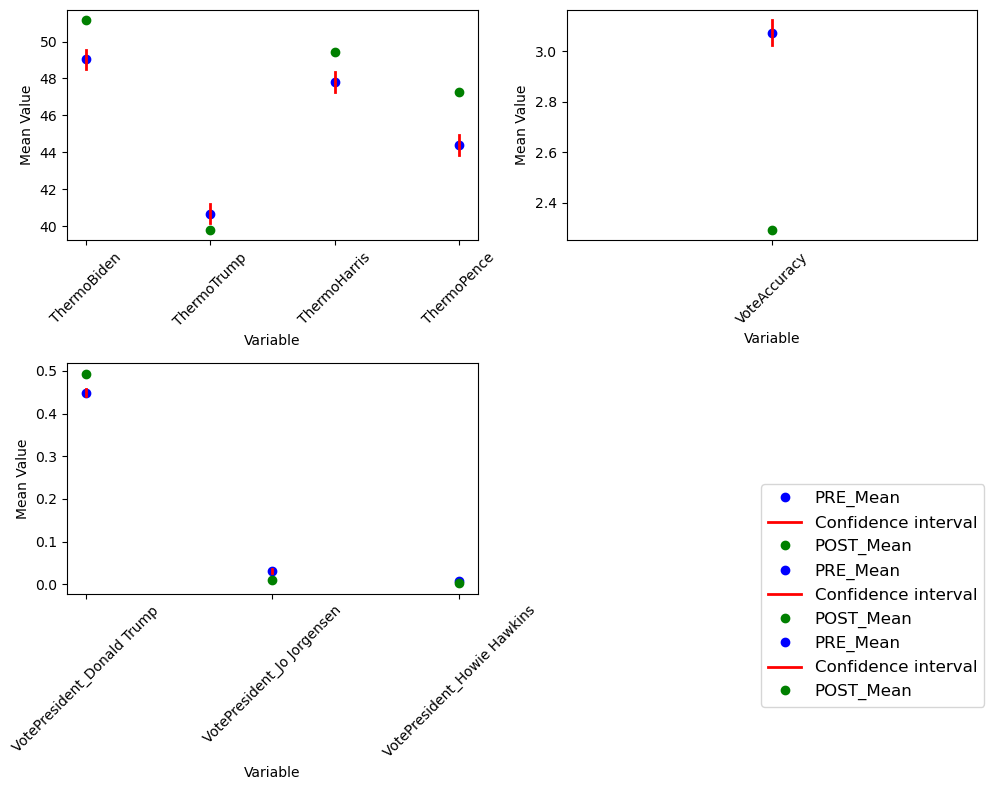

In [3]:
import matplotlib.pyplot as plt

unweighted_data = weighted_data = comparison_results

# Create a figure and axes for subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

# Loop for first 4 variables (subplot 1)
for i, var in enumerate(unweighted_data["Variable"][:4]):
    ax = axes[0]  # Use the first subplot (top-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i], unweighted_data["Unweighted_CI_Upper"][i]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Subplot 2 (for variable index 4)
ax = axes[1]  # Use the second subplot (top-right)
var = unweighted_data["Variable"][4]

# Plot the points for PRE_Mean
ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][4], 'o', color='blue', label='PRE_Mean')

# Add confidence interval lines
ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][4], unweighted_data["Unweighted_CI_Upper"][4]], 
        color='red', label='Confidence interval', lw=2)

# Plot the points for POST_Mean
ax.plot(var, unweighted_data["POST_Mean_Unweighted"][4], 'o', color='green', label='POST_Mean')

# Loop for remaining variables (subplot 3)
for i, var in enumerate(unweighted_data["Variable"][5:]):
    ax = axes[2]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, unweighted_data["PRE_Mean_Unweighted"][i+5], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [unweighted_data["Unweighted_CI_Lower"][i+5], unweighted_data["Unweighted_CI_Upper"][i+5]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, unweighted_data["POST_Mean_Unweighted"][i+5], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Remove the 4th subplot (bottom-right) by turning off its axis
axes[3].axis('off')

# Adjust the x-axis labels for all subplots (tilt them)
for ax in axes:
    ax.set_xlabel('Variable')
    ax.set_ylabel('Mean Value')
    ax.tick_params(axis='x', rotation=45)  # Tilt the x-axis labels

# Add the legend in the bottom-right of the figure
fig.legend(loc='lower right', bbox_to_anchor=(1, 0.1), fontsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


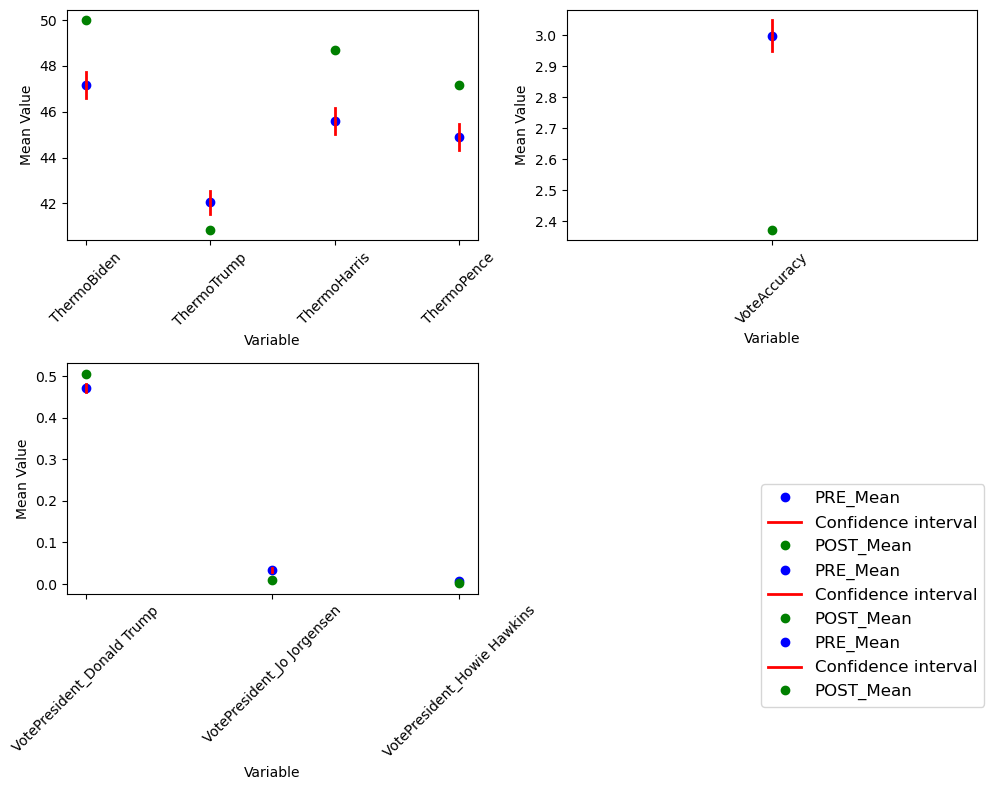

In [4]:
import matplotlib.pyplot as plt

unweighted_data = weighted_data = comparison_results

# Create a figure and axes for subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # 2 rows, 2 columns

# Flatten the axes array to iterate over them easily
axes = axes.flatten()

# Loop for first 4 variables (subplot 1)
for i, var in enumerate(weighted_data["Variable"][:4]):
    ax = axes[0]  # Use the first subplot (top-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i], weighted_data["Weighted_CI_Upper"][i]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Subplot 2 (for variable index 4)
ax = axes[1]  # Use the second subplot (top-right)
var = weighted_data["Variable"][4]

# Plot the points for PRE_Mean
ax.plot(var, weighted_data["PRE_Mean_Weighted"][4], 'o', color='blue', label='PRE_Mean')

# Add confidence interval lines
ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][4], weighted_data["Weighted_CI_Upper"][4]], 
        color='red', label='Confidence interval', lw=2)

# Plot the points for POST_Mean
ax.plot(var, weighted_data["POST_Mean_Weighted"][4], 'o', color='green', label='POST_Mean')

# Loop for remaining variables (subplot 3)
for i, var in enumerate(weighted_data["Variable"][5:]):
    ax = axes[2]  # Use the third subplot (bottom-left)
    
    # Plot the points for PRE_Mean
    ax.plot(var, weighted_data["PRE_Mean_Weighted"][i+5], 'o', color='blue', label='PRE_Mean' if i == 0 else "")
    
    # Add confidence interval lines
    ax.plot([var, var], [weighted_data["Weighted_CI_Lower"][i+5], weighted_data["Weighted_CI_Upper"][i+5]], 
            color='red', label='Confidence interval' if i == 0 else "", lw=2)
    
    # Plot the points for POST_Mean
    ax.plot(var, weighted_data["POST_Mean_Weighted"][i+5], 'o', color='green', label='POST_Mean' if i == 0 else "")

# Remove the 4th subplot (bottom-right) by turning off its axis
axes[3].axis('off')

# Adjust the x-axis labels for all subplots (tilt them)
for ax in axes:
    ax.set_xlabel('Variable')
    ax.set_ylabel('Mean Value')
    ax.tick_params(axis='x', rotation=45)  # Tilt the x-axis labels

# Add the legend in the bottom-right of the figure
fig.legend(loc='lower right', bbox_to_anchor=(1, 0.1), fontsize=12)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

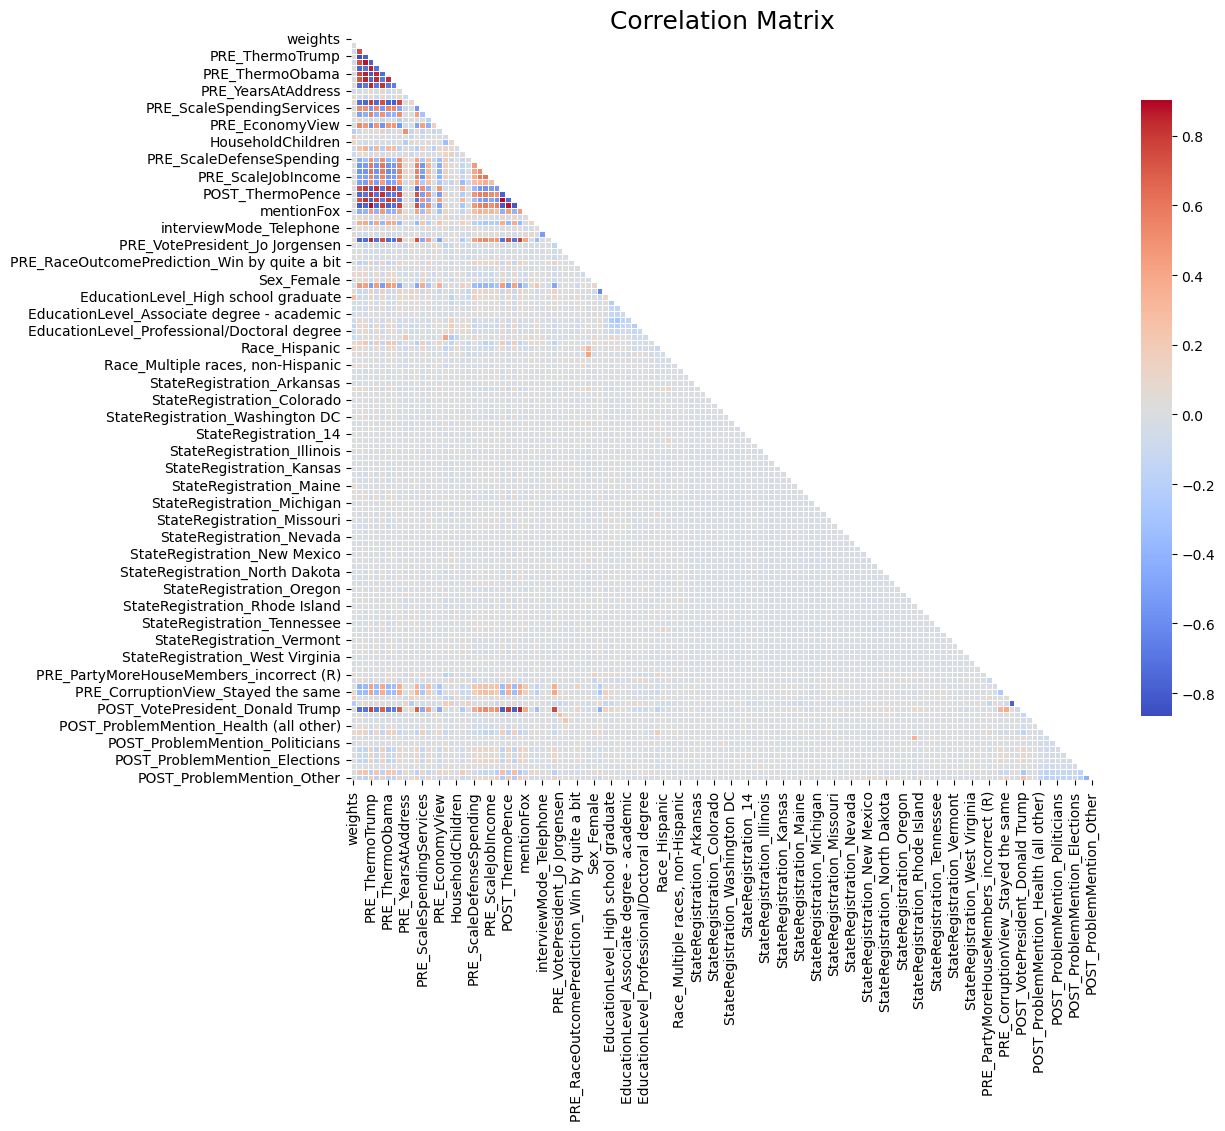

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix =  train_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap with customizations
sns.heatmap(correlation_matrix, 
            annot=False,                # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask = mask,
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,           # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 6})   # Adjust the font size for annotations

# Add title
plt.title('Correlation Matrix', fontsize=18)
plt.savefig('Correlation Matrix Heat Map')
plt.show()

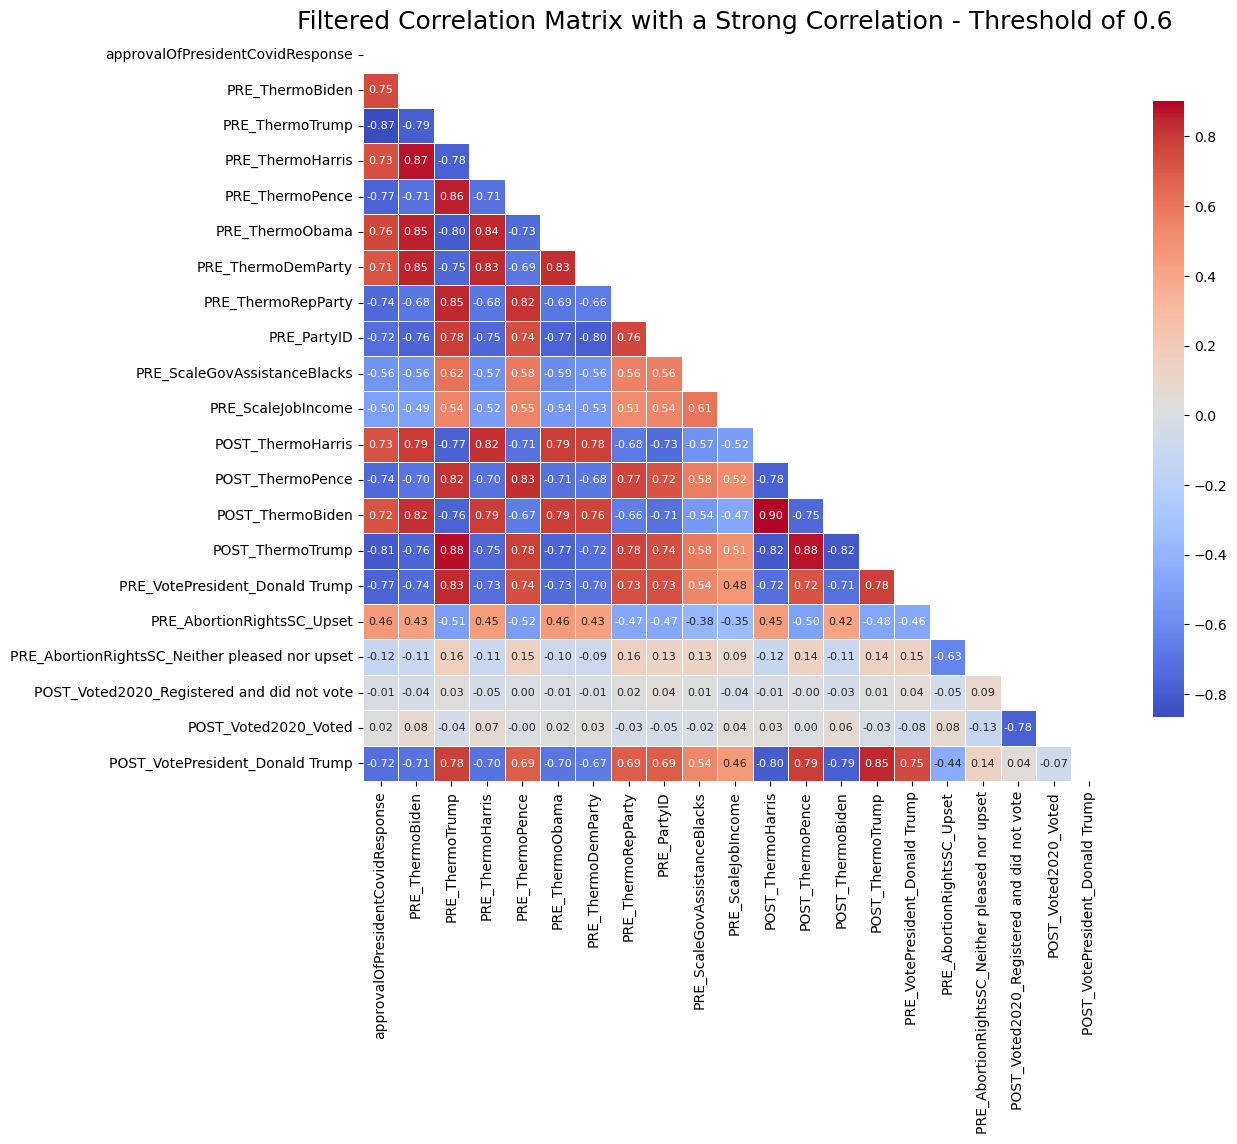

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define a threshold for strong correlations
threshold = 0.6

# Filter the correlation matrix
filtered_correlation_matrix = correlation_matrix.copy()
filtered_correlation_matrix[
    (filtered_correlation_matrix < threshold) & (filtered_correlation_matrix > -threshold)
] = np.nan  # Replace weak correlations with NaN
# Set diagonal elements to NaN
np.fill_diagonal(filtered_correlation_matrix.values, np.nan)

# Drop rows and columns that are completely NaN
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=0, how='all')  # Drop rows
filtered_correlation_matrix = filtered_correlation_matrix.dropna(axis=1, how='all')  # Drop columns

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(filtered_correlation_matrix, dtype=bool))

# Identify columns and rows that are not NaN in the filtered correlation matrix
valid_columns = filtered_correlation_matrix.dropna(axis=1, how='all').columns
valid_rows = filtered_correlation_matrix.dropna(axis=0, how='all').index

# Create a new plot matrix that only includes the valid rows and columns
plot_matrix = correlation_matrix.loc[valid_rows, valid_columns]
#print(plot_matrix)

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap with customizations
sns.heatmap(plot_matrix, 
            annot=True,               # Annotate cells with the numeric values
            fmt=".2f",                # Format the annotation text
            cmap='coolwarm',          # Color map
            mask=mask,                # Mask the upper triangle
            square=True,              # Make cells square-shaped
            cbar_kws={"shrink": .8},  # Color bar size
            linewidths=.5,            # Line width between cells
            linecolor='white',        # Line color between cells
            annot_kws={"size": 8})    # Adjust the font size for annotations

# Add title
plt.title('Filtered Correlation Matrix with a Strong Correlation - Threshold of '+str(threshold), fontsize=18)

# Save the plot
plt.savefig('Filtered_Correlation_Matrix.png', dpi=300)

# Show the plot
plt.show()

In [9]:
import importlib
# Import the function
from functions import explore_data_helper

# Reload the module to reflect any updates
importlib.reload(explore_data_helper)

# create a list of 100 perturbed versions of ames_train_preprocessed using the perturb_ames function
perturbed_data = [explore_data_helper.perturb_dataframe(train_data) for i in range(100)]

/Users/mjain/Desktop/MEng/DSWorkspace/electionAnalysis/dslc_documentation/functions/explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.95063423 0.66724863 4.02272488 ... 1.95130228 0.40164358 0.39365754]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
/Users/mjain/Desktop/MEng/DSWorkspace/electionAnalysis/dslc_documentation/functions/explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-9.20904329 73.85247714 43.88467776 ... 72.90664763 14.79170032
 86.1227468 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_perturbed.loc[perturb_indices, col] += noise
/Users/mjain/Desktop/MEng/DSWorkspace/electionAnalysis/dslc_documentation/functions/explore_d

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.42523652 4.41692381 4.01473698 ... 4.00585472 3.82864005 3.67475642]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[59.39353033  0.69434593 16.83088277 ... 36.28086815 75.03195508
 98.39836836]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.18335493 4.63271085 4.4578115  ... 4.42867858 3.84353259 2.57173675]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  4.08773158  53.80673767  41.95720849 ...  99.07659938 116.28494766
  86.77038728]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.73766716 4.08923988 2.88381779 ... 4.25682054 0.63702178 3.51278344]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[101.97431959  22.72820298  35.86494281 ...   4.18606528   0.76799887
  56.04205599]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.6125867  0.85847747 3.46624152 ... 1.24300814 3.39411769 4.07911651]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 56.91930766  46.33154609  30.81606364 ...  64.93344507  36.26346972
 106.35139263]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.68975472 4.38910052 1.42883368 ... 3.44402331 4.37594265 0.82572611]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  6.36400403  42.39393497  25.81000313 ...  47.0390757   23.8809967
 -14.61008875]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.67719163 2.42245894 3.97747502 ... 3.37854822 3.90067619 4.28031847]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 49.90851326 112.61806197  48.71153147 ...  20.97461613  35.43242827
  69.96450497]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.45831988 3.4564557  3.64689512 ... 4.00330061 0.41313007 4.22254338]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[78.06189043 56.25586431 92.01641038 ... 99.66617265 87.16772645
 19.96853402]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.66267505 3.60056635 0.87107103 ... 1.73443118 1.04970603 3.90789447]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 81.75767721 103.61531639  79.77106688 ...  42.6938653    8.42235252
 -15.7003246 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.50073061 4.28795916 3.7362048  ... 3.54009235 3.92133047 2.0776137 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 44.49557022 114.52653949  75.84966759 ...  69.31599777  82.06074476
  72.02182112]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.35295617 2.17064382 3.46985468 ... 3.99285847 3.79324408 3.47235379]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 72.41987338  11.36906967 112.15361397 ...  10.6759505   55.52158049
  53.41419126]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.99189761 4.36345332 4.10220089 ... 3.36142274 0.71533861 0.51725063]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 84.46265334 -16.06294204  37.92787518 ...   6.31078585  70.50524732
  71.30997927]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.43486588 2.25787986 3.56319305 ... 3.36244433 1.23610494 4.64531959]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 14.59267257 104.53418983  39.72934222 ...  55.11767215  94.04138651
  72.18327277]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.13742235 1.55878881 3.55564985 ... 4.2533668  1.97024189 2.30807713]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[48.14024439 82.19035421 -3.8660027  ...  1.61866128 74.88251033
 10.12934276]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.65349994 4.56006851 1.22005954 ... 0.97863211 1.60671095 0.43879963]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[53.74409475 83.79620511 69.11738759 ... 87.36741748 19.09634618
 38.49748315]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.11638941 3.46787704 3.90030949 ... 1.61681382 1.90676097 1.60730743]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[74.66735494 38.45093211 72.04499972 ...  0.2463194  84.6772573
 19.28269768]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functi

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.99514917 4.26003024 3.50910548 ... 1.8958823  3.45079162 3.41696161]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[15.70835442  9.88599818 55.18709168 ... 96.5812511  13.75287983
 46.32431959]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.55977824 3.72590611 1.29482382 ... 1.30038658 2.26014544 2.25133602]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 96.83364787 -13.42415113  13.02115227 ...  56.69950398   4.57710376
  68.46548424]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.59528888 2.05979143 3.52889417 ... 2.35547059 3.57406141 4.12535266]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 92.63134354  68.17604649  19.70225733 ...  50.03066733  65.38665062
 113.41939045]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.52838533 3.70895949 3.78723262 ... 1.10350965 4.47151268 3.47825901]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[63.85222417 45.8069566  63.0507824  ... 64.60239978 23.3765799
 56.17415677]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functi

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.04333157 2.27758405 2.31275412 ... 2.68159641 1.50900966 4.32183589]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 8.87560912 83.16243289 78.86338363 ... 88.29286628 78.86371036
 86.95140824]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.22843114 4.20532877 0.56290393 ... 1.99461732 4.56842765 3.5953912 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 67.37758207  15.58366038   5.66929553 ...  28.11398316 -11.86956201
 109.44371067]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.72794556 3.64222046 2.17775734 ... 3.90644326 3.83241316 3.56372132]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  4.66506787  93.85438198 102.70340878 ...   5.92079213  68.30939764
  57.28375942]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.06184996 4.57191199 3.73806547 ... 0.80596735 4.46544458 3.55426339]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -5.11813926  97.34159695  72.74482352 ...  76.51043769  42.86915312
 -14.62200782]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.41184267 4.04036046 1.3867774  ... 2.72029251 3.96822231 4.33363692]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[45.37515235 34.50239613  1.85842958 ... 65.33115466 62.21129276
 41.48049862]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.54130532 2.45900055 3.74298162 ... 1.26974613 3.99749079 4.53530233]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 81.23511316  74.31890479  93.40299681 ...  53.31783859  12.19266362
 -15.21800398]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.48812689 2.94862254 4.12602184 ... 0.95717661 3.48890181 4.02270912]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 23.33875348  15.72476478  23.88658337 ...  71.5070359   24.21824037
 -13.60238452]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.44780191 3.42151542 4.54622976 ... 1.58288112 4.00963456 3.13761417]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[82.84592456 81.99843333 28.74693187 ... 77.21240203 86.41913717
 73.21102091]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.42583392 4.60967661 1.59213146 ... 3.79749416 1.87556794 1.38205939]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 87.47869869 107.39988353  44.96508221 ...  26.65881494  47.08487798
  45.88230696]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.06370135 1.34193067 3.58441397 ... 3.8351265  3.39513435 2.38946328]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-13.86588315  71.13213484   1.3022759  ...  12.01521288  66.98753812
  46.42165582]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.42889767 4.4745449  3.62591788 ... 4.16722238 4.37869191 1.13476072]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[66.19986146 38.15159487 42.93699511 ... 66.31934237 92.6324289
 -7.29629203]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functi

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.89574836 1.21576615 3.85892843 ... 2.41346343 1.4606373  4.21202243]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 80.18243555  69.87613998 -12.00285208 ...  84.95302283   4.71671693
  14.55978913]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.67097518 1.51611244 3.95711493 ... 3.82448212 1.10527559 3.36712945]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  6.34013212  -8.1465452   37.97212637 ...  36.60960976  70.68741189
 -11.7785275 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.43731029 0.67215432 2.57408657 ... 4.5979732  3.52076375 4.1478686 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[56.71414293 77.16056032 99.30109794 ...  3.50793949 84.84325458
 44.30066418]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.4162279  4.14032698 0.40253586 ... 3.88264036 1.86340744 4.40623794]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 95.83418791  76.55543306  71.11572333 ...  76.22059463 -12.33261986
 108.86237916]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.77199808 4.18468906 1.99383831 ... 2.77539047 3.96363994 4.13426533]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 92.11618625 101.30880986   6.21959612 ...  79.31873616  -4.27695966
  96.65338239]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.63447561 3.68908557 1.50518571 ... 0.36000746 4.39426309 2.61038204]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 96.52354947 106.11520098  31.80957226 ...  88.36647346  -3.64722894
  83.72016156]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.96733225 2.45194148 3.60601976 ... 0.89476185 1.63385627 1.16967773]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 56.9401336  107.23441813  92.31437442 ... 107.28544207   1.45246338
  85.96226064]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.36031052 4.5584661  1.49116581 ... 0.39630597 0.77512977 4.01152296]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 9.58294832 -0.98351429 65.78679035 ... 64.1312633  79.21485095
 70.25547114]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.607083   1.12291102 1.6832452  ... 1.37037364 2.51459281 3.37981726]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[53.19740861 89.6385596  13.74336806 ... 13.36284234 57.54645788
 60.47501543]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.68347724 1.4864127  3.81281415 ... 4.62667692 1.55739888 3.48328551]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-15.85161842  56.43520707  95.01109336 ...  70.96531941  75.89068407
  14.71729252]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.57435762 4.65074351 1.50632072 ... 1.26562026 4.58917468 3.71148949]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 78.90756812  86.6201856   60.53125087 ...  36.23496831 107.53901554
  39.87001856]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.5867302  4.55497974 0.71440311 ... 1.56078415 4.3554594  3.51242751]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 17.05003478  15.68466467  74.82768569 ...  61.39820486 101.82332596
   2.29253552]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.37093787 3.86840157 1.27453212 ... 1.5593618  4.40446829 2.86552278]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[64.51176323 97.38049012 98.85903242 ... 72.12614053 95.55563291
 36.52158138]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.31553257 3.90826918 3.75879853 ... 3.5597629  3.37151299 1.5699883 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  9.24764736  43.3037047   56.28345897 ... -13.91550006   1.40826276
  85.08195582]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.35455477 3.96372505 4.47477444 ... 4.1406637  3.60817288 4.48219254]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 59.41814034 112.50036722  73.59954649 ...  55.04031147  95.7296154
  19.13270202]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.57583991 4.09017518 0.43114204 ... 0.45339061 3.19444493 3.50042219]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[111.96763425  85.93585612   2.37254857 ...  26.36820747  85.73085305
  94.01628646]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.53593124 1.08447337 3.90879951 ... 4.43159647 4.16090553 1.36635442]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 86.7515278    3.69093468  55.52198149 ...  73.9239261  -11.15374657
  15.36344003]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.66171487 0.53381945 3.82080945 ... 4.49271786 1.5035569  4.52586884]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 8.69712792 71.54297777 56.15422113 ... 16.41797835 87.83109965
 80.47143174]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.76849888 4.64517352 4.3360133  ... 0.71036652 4.5496684  2.92242366]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 52.37341214  -1.86954945  90.09888968 ...  10.19911565  85.76343045
 -15.57202131]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.63557907 3.78558714 0.73224665 ... 0.4866452  1.35823591 3.52169008]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ -6.30070037   6.97569612  47.56441157 ...  23.48844582  69.90038233
 107.4124822 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.87005164 1.44838134 1.20512942 ... 2.54372234 1.54239472 4.45134314]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[107.83092223  76.3303823   21.01067959 ...  79.12413899  73.63489491
  84.45072976]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.76758671 3.98011788 3.52801335 ... 0.87882472 1.43046944 3.63869248]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  6.11979455  28.46120797  76.0978666  ...  40.32138449  47.99274368
 -13.87285187]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.18080477 1.0934753  4.30163466 ... 4.37389458 4.19033055 4.03308663]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  2.95063149  25.42877625  23.04498378 ... 104.5141762   59.09015358
  36.77974195]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.41718454 1.0847222  4.46371671 ... 4.08714983 4.13854172 3.01996341]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[67.87442646 37.19566361 48.95379568 ... 27.02363933 47.12417369
 42.10968343]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.48100153 1.31291211 4.09932279 ... 4.4641511  0.99147843 2.41771855]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[109.25668263  11.11894583   5.38531649 ...  25.91896104  86.62413333
  31.39942968]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.90709562 3.79949312 3.53615411 ... 3.92361169 3.96443409 3.74482579]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[22.11018807 45.99953346 -6.40823129 ...  4.63977204 97.58052821
 -9.71890546]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.75959704 0.40246219 3.96247499 ... 1.83180563 1.65752123 4.34459546]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[92.07886545 16.16275705 -3.27759889 ... 55.43895291 55.05171704
 32.82669116]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.53277953 2.63242291 3.46693976 ... 4.23802006 0.96930994 4.46787572]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 63.22975872  32.36430436  71.27264132 ...  25.50219641 -11.56796972
 100.8300255 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.61438729 3.78438613 3.96825757 ... 3.48311122 3.6637722  3.66994821]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[45.24388078 55.63531065 13.77076363 ... 37.30287128 15.02889918
 60.20379203]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.56642329 1.3724799  0.57959023 ... 3.95752837 3.59648787 1.08473849]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 74.64669428  -9.19699738  73.12734914 ...  75.06520995 103.67189209
 100.43356447]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.35247448 4.28004891 3.64119173 ... 0.45677675 0.94846266 1.51207141]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[54.60824759 19.30660515 90.18935269 ... 16.07209656 10.02331894
 49.36543885]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.57935087 2.52738191 1.24690558 ... 1.25820427 1.30858069 4.31890439]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-5.34770828 87.51460178 -1.39219549 ... 21.40736885 95.33191859
 69.23994181]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.53521184 2.58470232 0.41412197 ... 4.31770289 1.4234078  0.95217684]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 84.26065025 100.80529554 -16.76198215 ... -11.86389308  71.66959627
  93.85521277]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.38992615 3.37796931 3.97187742 ... 1.46840804 1.71838736 4.43214307]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  3.32183254  33.61185533  58.0977068  ... -14.98524135  87.89044381
  74.05221706]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.38752041 3.67365962 2.605041   ... 1.59044903 3.64551935 2.72259333]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 12.44997346 -10.36395973   1.03502149 ...  62.74186702  35.78144647
  82.35232016]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.54326306 3.91272011 4.10306707 ... 0.87630024 3.68115135 2.18394805]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[79.77727845 68.40127659 65.26296267 ... 37.99540874 57.32526731
 -3.03769648]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.29686595 1.35119502 4.60842915 ... 4.56952624 3.62289881 0.99632781]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[72.03752449 11.6250994  55.06359082 ... 43.61980124 18.39391952
 -7.32134496]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.95137897 2.09298264 4.57785241 ... 3.86002578 4.3603477  3.06216141]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[80.59555917 89.98421163  4.7382704  ...  0.11703527 94.49887425
 83.73885409]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.54032624 0.61207063 1.02979337 ... 3.52857282 1.58974343 1.8097396 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[52.11646638 15.45784205 98.28028717 ... 74.37372242 77.35160762
 57.5197753 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.99498519 3.80826408 3.52675414 ... 1.46369492 4.44454094 2.44624169]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1.40254083 -9.96152222 65.17798215 ... 54.40847221 78.83766715
 74.95839284]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.60507225 4.37507925 3.72355536 ... 3.47107241 2.39195277 1.17857251]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[101.39428775  84.23530263  55.11532415 ...   0.31650974  -1.09134789
  83.86357671]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.20996934 2.76658052 0.72677455 ... 3.70689269 3.37090927 4.13687274]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[15.40178711 34.63175065 92.99201242 ... 69.90207022 83.8774546
 49.50865703]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functi

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.42896162 3.39361839 3.53026689 ... 2.05530774 3.56054013 4.46894979]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[74.28839668 94.86673392 83.45129123 ... 79.68232538  6.06181551
 88.98547635]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.75761068 3.86980276 2.0729763  ... 0.99663876 4.57622784 2.46682349]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[80.15826948 79.22289022 67.41951718 ... 86.42496502 66.93296833
 25.06512511]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.3673891  3.79949973 2.5240999  ... 4.41540319 3.86215657 4.46878932]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-17.05315954  67.04744818  84.74752431 ...  16.48511781  75.20004507
 103.56809524]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.31597125 4.52941429 3.2228628  ... 4.5073103  0.35588816 1.52930358]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 74.74881511   5.58479438  55.17079043 ... 101.55224836  28.6521703
  43.94225507]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.10519987 3.52490187 3.86927481 ... 4.22991996 3.23369816 3.87525495]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[26.81835863 91.25765062 53.01232196 ... 89.5078303  43.01128728
 70.31271575]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.18844973 4.50401372 0.51597977 ... 1.28279864 3.64152383 3.67810083]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 32.57587217  65.66500304  16.51970088 ...  -1.2593526   44.29944648
 115.22295373]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.78090004 3.61971441 1.871031   ... 4.16169105 4.48358804 0.63946647]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-8.03983705 88.10354714 35.65537551 ... 73.6528911  56.32831349
 53.76929723]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.20758277 0.953019   2.15183532 ... 4.47829395 3.83264225 1.02278954]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.5652662  19.33802749 80.22770032 ... -3.21484407 51.68481483
 61.46845228]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.04613859 4.42426186 2.26607997 ... 1.66531803 4.51274399 0.90466006]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[45.86417433 89.1382323  35.42603239 ... 72.74828388  3.57930793
 -3.43654629]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.69204483 3.58333655 3.82556555 ... 3.52922806 4.2464387  0.59132523]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[97.12615751 11.35640419 94.75815785 ... 28.79321119 -5.54675013
 40.37353115]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.58165568 2.445044   2.41006956 ... 2.03143213 1.60071011 4.33439807]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[34.97736839 70.85758725 93.62498436 ... 30.70146944 26.20633752
 76.01102989]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.24620502 4.22036369 0.93011709 ... 0.65478429 0.73424532 4.17651105]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 56.4719108   44.51581577  -1.79791203 ... -14.22619428  54.71735043
  -8.01106146]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.3522001  0.55100227 2.39604621 ... 1.45008679 1.09741424 0.98471686]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[72.61078126 26.33087615 54.75888356 ... 82.38866633 47.57932985
 15.14881049]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.95719124 3.29441863 3.95992965 ... 4.08346331 4.12808934 2.50287623]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[99.53303519 40.34820245 28.29904487 ... 37.57929293 30.86948487
 -7.79457495]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.22272892 3.79492694 3.79600783 ... 4.64974546 3.55932247 4.05342086]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 54.7870848   97.25899507  70.61439292 ...   5.24762946 -12.4300821
  25.32863846]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.60738285 4.02932548 4.47452007 ... 4.62463463 3.96179352 1.24660601]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[86.19704091 -6.97441574 98.40546358 ... 35.01628277 65.04109962
 34.63200238]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.42966336 4.62221281 1.5017485  ... 1.56937506 0.58064983 4.60227434]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-2.07871669 33.08589433 -9.1770743  ... 98.72535192 96.3168528
 12.56227993]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functi

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.46838639 1.35561349 3.49130032 ... 0.53900222 3.43484177 0.56229831]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 59.08555804  54.03313118  55.34433438 ...  51.743474   103.44282191
  60.69060969]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.34605942 3.37724276 4.10977458 ... 3.64967359 1.77751302 0.78672916]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 23.06124955  97.48310538 -10.03647424 ...  71.31645392  96.33344484
  66.80365895]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.51369577 2.92664862 4.15092052 ... 1.58807489 1.95000042 4.24641534]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 66.69572968  77.13451272  39.66803712 ...   0.15824436 101.04785147
 112.34033149]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.42067053 0.9813797  0.35471545 ... 4.16036609 4.292059   3.66230677]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[104.67617807  65.98538455  87.24464828 ... -12.30612182  64.38174846
  -7.55837409]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[3.90413995 3.61691203 3.87137962 ... 0.48810935 4.57449898 0.55283537]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 5.49287345  6.40682229 41.83232133 ... 45.15220871 83.6967507
 89.89960924]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functi

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.37034668 3.7012573  3.85202965 ... 3.29733218 2.21632149 4.61297044]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[94.95957174 12.54183256 75.39652206 ... -5.11699197 85.83738043
 84.24808699]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.60642003 3.74540853 3.63959346 ... 0.38005297 3.66463355 3.49650161]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 3.86495843 75.92404378  7.92054956 ... 43.62572591 86.70881743
 62.40081335]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[4.55747082 1.38043417 4.61390969 ... 4.29361712 4.19308406 3.6587033 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\functions\explore_data_helper.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[87.70951047 12.57739501 90.85844551 ... -1.32000089 68.27891062
 77.73625621]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  
C:\Users\15184\OneDrive\Documents\Statistical Principals for Data Science\electionAnalysis\dslc_documentation\funct

In [10]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

# Assuming train_data and perturbed_data are DataFrames
# Assuming explore_data_helper.perturb_dataframe is defined

# Step 1: Calculate the mean for each column in train_data
train_means = train_data.mean()

# Step 2: Calculate the means for each perturbed dataset and store the results
perturbed_means = []

for perturbed_df in perturbed_data:
    perturbed_means.append(perturbed_df.mean())

# Step 3: Perform T-tests to compare means for each column between train_data and perturbed datasets
p_values = {}

# Iterate over each column in the train_data (and perturbed data)
for column in train_data.columns:
    # Get the mean of the train_data for this column
    train_column_values = train_data[column]
    
    # Store the p-values for each perturbation (compare with the train data)
    p_vals_for_column = []
    
    for perturbed_mean in perturbed_means:
        perturbed_column_values = perturbed_mean[column]
        
        # Perform a two-sample t-test between the train data and perturbed data
        t_stat, p_val = ttest_ind(train_column_values, perturbed_column_values)
        p_vals_for_column.append(p_val)
    
    # Store the average p-value for this column across all perturbations
    p_values[column] = np.mean(p_vals_for_column)

# Step 4: Analyze p-values to check for statistically significant differences
# Typically, a p-value below 0.05 suggests a significant difference
significant_columns = {col: p_val for col, p_val in p_values.items() if p_val < 0.05}

# Print columns with significant differences
print("Columns with significant differences (p-value < 0.05):")
for col in significant_columns:
    print(f"{col}: p-value = {significant_columns[col]}")


Columns with significant differences (p-value < 0.05):
interviewMode_Telephone: p-value = 0.02946283152538386
PRE_VotePresident_Howie Hawkins: p-value = 0.0004961568450684268
PRE_VotePresident_Other: p-value = 0.002191602356908347
Race_Native American/Alaska Native, non-Hispanic: p-value = 0.04452214394363952
StateRegistration_Alaska: p-value = 1.8107274572726128e-20
StateRegistration_Arizona: p-value = 0.0269955735792281
StateRegistration_Arkansas: p-value = 0.0002971426995612898
StateRegistration_7: p-value = 1.6248604293616004e-110
StateRegistration_Colorado: p-value = 0.026056606318239403
StateRegistration_Connecticut: p-value = 0.0019846423716735908
StateRegistration_Delaware: p-value = 2.9340484215167197e-10
StateRegistration_Washington DC: p-value = 1.3005383920892087e-05
StateRegistration_14: p-value = 1.8052358960494004e-20
StateRegistration_Hawaii: p-value = 2.277224063076361e-06
StateRegistration_Idaho: p-value = 0.0031484603553241204
StateRegistration_Iowa: p-value = 0.0020

In [97]:
p_values

{'weights': 0.9987383764612906,
 'approvalOfPresidentCovidResponse': 0.9986613942593255,
 'PRE_ThermoBiden': 0.9987049822257184,
 'PRE_ThermoTrump': 0.9987412723474661,
 'PRE_ThermoHarris': 0.9986737150087996,
 'PRE_ThermoPence': 0.9987727802146477,
 'PRE_ThermoObama': 0.9987650607132516,
 'PRE_ThermoDemParty': 0.9989892635185379,
 'PRE_ThermoRepParty': 0.9986199093898266,
 'PRE_YearsAtAddress': 0.9987412046021332,
 'PRE_SummaryVoteDutyChoice': 0.9986704126859067,
 'PRE_PartyID': 0.9987944550421107,
 'PRE_ScaleSpendingServices': 0.998745857281524,
 'PRE_CountryDirection': 0.9986727609433078,
 'PRE_GovTrust': 0.998499178165096,
 'PRE_EconomyView': 0.9987665726120973,
 'Age': 0.9987282598812591,
 'Income': 0.9985466084425522,
 'HouseholdChildren': 0.998761315937484,
 'PRE_VoteAccuracy': 0.99867377449204,
 'PRE_SurveySeriousness': 0.9986080194183329,
 'PRE_ScaleDefenseSpending': 0.9987468232051916,
 'PRE_ScaleMedInsurance': 0.9985643621808138,
 'PRE_ScaleGovAssistanceBlacks': 0.9987836897

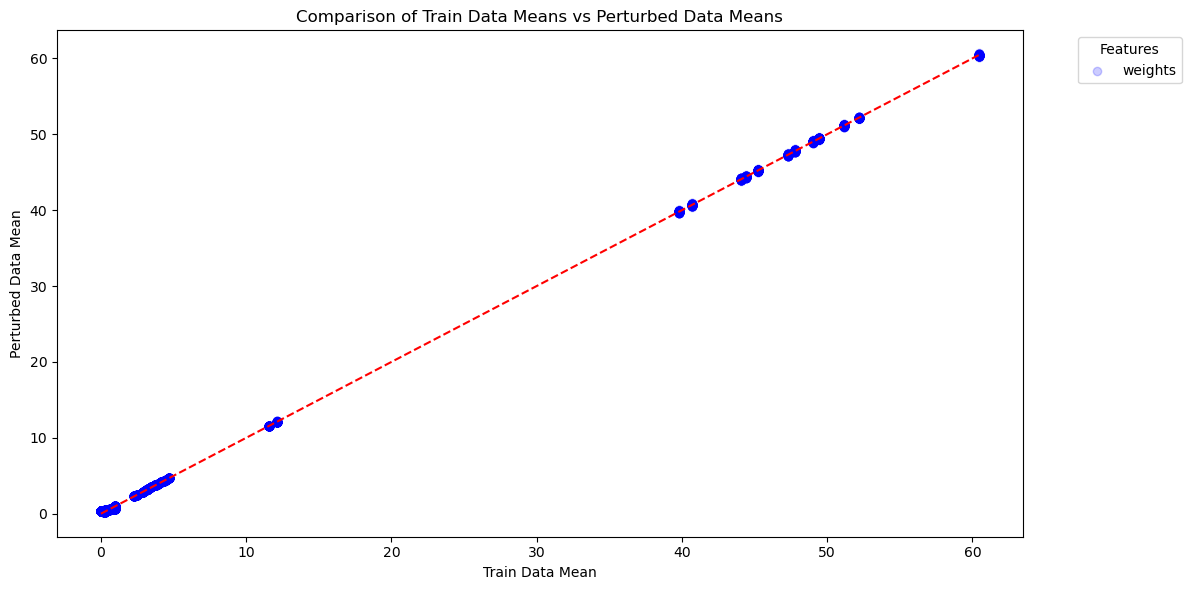

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Convert list of means for perturbed data to a DataFrame
perturbed_means_df = pd.DataFrame(perturbed_means)

# Step 3: Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot of perturbed means (y) vs train means (x)
for i, feature in enumerate(train_means.index):
    ax.scatter(np.repeat(train_means[feature], len(perturbed_means)), perturbed_means_df[feature].values, 
               color='blue', alpha=0.2, label=f'{feature}' if i == 0 else "")
    
# Add a line for perfect agreement (y = x)
plt.plot([min(train_means), max(train_means)],
         [min(train_means), max(train_means)], color='r', linestyle='--')

# Add labels and title
ax.set_xlabel('Train Data Mean')
ax.set_ylabel('Perturbed Data Mean')
ax.set_title('Comparison of Train Data Means vs Perturbed Data Means')

# Optionally, add a legend to describe features
ax.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

def compare_means_by_mode(perturbed_data, key_word):
    """
    Compare means of columns where 'interviewMode' is in the column name, 
    grouped by the interview mode categories (True/False).
    
    Parameters:
        perturbed_data (list of pd.DataFrame): List of DataFrames containing the perturbed data to analyze.
    
    Returns:
        p_vals (list of tuples): List of columns and their corresponding p-values from the t-tests.
    """
    p_vals = []
    
    # Iterate over each DataFrame in the list
    for i, df in enumerate(perturbed_data):
        print(f"\nAnalyzing DataFrame {i + 1}...\n")

        # Identify all columns that contain 'interviewMode' in their name
        interview_mode_columns = [col for col in df.columns if key_word in col]
        
        if not interview_mode_columns:
            print("No 'interviewMode' columns found.")
            continue
        
        #print(f"Found interview mode columns: {interview_mode_columns}")
        
        # Loop over all the numerical columns for comparison
        for col in df.select_dtypes(include=np.number).columns:
            #print(f"\nComparing column '{col}' based on interview modes.")

            # Compare the data for each interview mode column (True vs. False)
            for mode in interview_mode_columns:
                mode_true_data = df[df[mode] == True][col]  # Data where mode is True
                mode_false_data = df[df[mode] == False][col]  # Data where mode is False
                
                # Perform t-test between the two interview modes for this numerical column
                t_stat, p_value = ttest_ind(mode_true_data, mode_false_data, nan_policy='omit')
                
                # Append p-value for the column to the list
                p_vals.append((col, p_value))
                
                # Print results
                if p_value < 0.05:
                    print(f"The means for {mode} (True vs False) are significantly different in column '{col}'.")

    return p_vals


In [13]:
p_vals = compare_means_by_mode(perturbed_data, 'interviewMode')


Analyzing DataFrame 1...

The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 2...

The means for interviewMode_Web (True vs False) are significantly different in column 'weights'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoBiden'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoHarris'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_SummaryVoteDutyChoice'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_VoteAccuracy'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PO

The means for interviewMode_Web (True vs False) are significantly different in column 'POST_VoteAccuracy'.

Analyzing DataFrame 34...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'approvalOfPresidentCovidResponse'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoBiden'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoTrump'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoHarris'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoPence'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoObama'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ThermoDemParty'.
The means for interviewMode_Telephone (True vs False) are significa

The means for interviewMode_Telephone (True vs False) are significantly different in column 'mentionFox'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionFox'.

Analyzing DataFrame 49...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_YearsAtAddress'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'Age'.
The means for interviewMode_Web (True vs False) are significantly different in column 'Income'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'HouseholdChildren'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionFox'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionCNN'.

Analyzing DataFrame 50...

The means for in


Analyzing DataFrame 63...

The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 64...

The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_YearsAtAddress'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'Income'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'POST_VoteAccuracy'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 65...

The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_SummaryVoteDutyChoice'.
The means for interviewMode_Web (True vs False) are significantly different in column 'Income'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_VoteAccuracy'.
The means for interviewMode_Web (True vs False) are significantly dif


Analyzing DataFrame 78...


Analyzing DataFrame 79...

The means for interviewMode_Web (True vs False) are significantly different in column 'HouseholdChildren'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'PRE_ScaleDefenseSpending'.

Analyzing DataFrame 80...

The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_PartyID'.
The means for interviewMode_Telephone (True vs False) are significantly different in column 'mentionABC'.
The means for interviewMode_Web (True vs False) are significantly different in column 'mentionABC'.

Analyzing DataFrame 81...

The means for interviewMode_Web (True vs False) are significantly different in column 'weights'.
The means for interviewMode_Web (True vs False) are significantly different in column 'approvalOfPresidentCovidResponse'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ThermoObama'.
The means for interviewMode_We

The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ScaleMedInsurance'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ScaleJobIncome'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_VoteAccuracy'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_ThermoHarris'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_ThermoBiden'.
The means for interviewMode_Web (True vs False) are significantly different in column 'POST_ThermoTrump'.

Analyzing DataFrame 92...

The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_SurveySeriousness'.
The means for interviewMode_Web (True vs False) are significantly different in column 'PRE_ScaleDefenseSp

In [14]:
from collections import Counter

# Example of tracking how often each feature is significant
significant_features = [col for col, p_value in p_vals if p_value < 0.05]

feature_counts = Counter(significant_features)
sorted_feature_counts = feature_counts.most_common()

print(f"Features with the most significant differences: {sorted_feature_counts}")


Features with the most significant differences: [('mentionABC', 48), ('PRE_SurveySeriousness', 28), ('weights', 26), ('PRE_ThermoBiden', 23), ('PRE_CountryDirection', 22), ('mentionFox', 22), ('Income', 19), ('PRE_SummaryVoteDutyChoice', 18), ('PRE_ThermoHarris', 17), ('PRE_ThermoDemParty', 17), ('PRE_VoteAccuracy', 15), ('PRE_PartyID', 13), ('Age', 12), ('PRE_ScaleDefenseSpending', 11), ('mentionCNN', 11), ('PRE_ScaleJobIncome', 11), ('POST_VoteAccuracy', 10), ('PRE_ScaleGovAssistanceBlacks', 10), ('PRE_ThermoObama', 10), ('HouseholdChildren', 9), ('PRE_EconomyView', 9), ('PRE_YearsAtAddress', 8), ('POST_ThermoBiden', 8), ('POST_ThermoHarris', 7), ('POST_ThermoPence', 7), ('PRE_GovTrust', 6), ('approvalOfPresidentCovidResponse', 6), ('PRE_ScaleMedInsurance', 6), ('PRE_ThermoTrump', 5), ('PRE_ThermoRepParty', 5), ('POST_ThermoTrump', 5), ('PRE_ThermoPence', 4), ('PRE_ScaleSpendingServices', 4)]


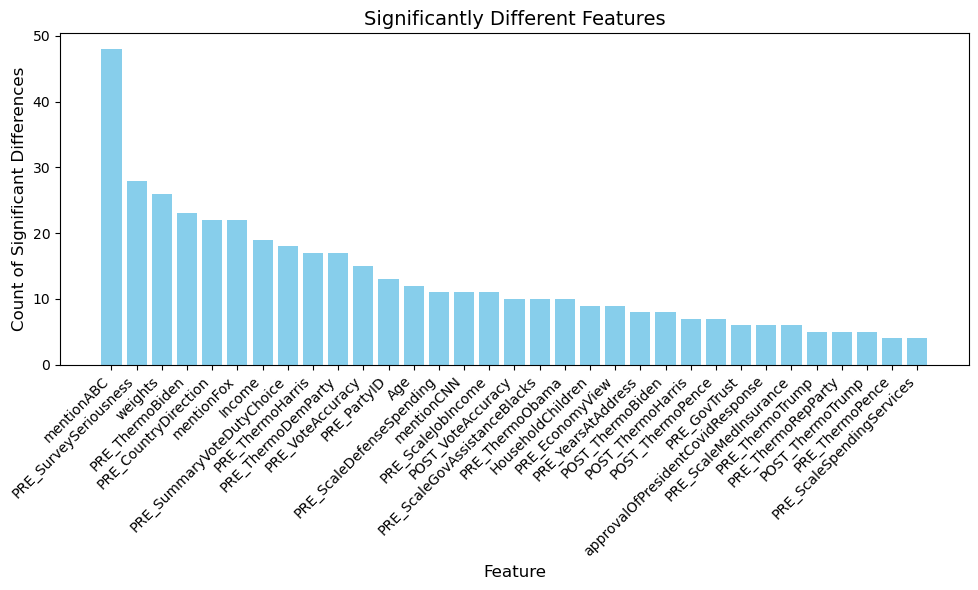

In [15]:
# Separate the feature names and their counts
features, counts = zip(*sorted_feature_counts)

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(features, counts, color='skyblue')

# Adding titles and labels
plt.title('Significantly Different Features', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Count of Significant Differences', fontsize=12)

# Rotate feature names if they are too long
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

# Census

In [103]:
# Standardized Race Labels
RACE_LABELS = {
    1: 'White, non-Hispanic', 
    2: 'Black, non-Hispanic', 
    3: 'Hispanic', 
    4: 'Asian/Pacific Islander, non-Hispanic', 
    5: 'Native American/Alaska Native, non-Hispanic', 
    6: 'Multiple races, non-Hispanic'
}

GENDER_LABELS = {
    1: 'Male', 
    2: 'Female'
}

STATE_MAPPING = {
    1: "Alabama", 2: "Alaska", 4: "Arizona", 5: "Arkansas", 6: "California",
    8: "Colorado", 9: "Connecticut", 10: "Delaware", 11: "Washington DC",
    12: "Florida", 13: "Georgia", 15: "Hawaii", 16: "Idaho", 17: "Illinois",
    18: "Indiana", 19: "Iowa", 20: "Kansas", 21: "Kentucky", 22: "Louisiana",
    23: "Maine", 24: "Maryland", 25: "Massachusetts", 26: "Michigan",
    27: "Minnesota", 28: "Mississippi", 29: "Missouri", 30: "Montana",
    31: "Nebraska", 32: "Nevada", 33: "New Hampshire", 34: "New Jersey",
    35: "New Mexico", 36: "New York", 37: "North Carolina", 38: "North Dakota",
    39: "Ohio", 40: "Oklahoma", 41: "Oregon", 42: "Pennsylvania", 44: "Rhode Island",
    45: "South Carolina", 46: "South Dakota", 47: "Tennessee", 48: "Texas",
    49: "Utah", 50: "Vermont", 51: "Virginia", 53: "Washington", 54: "West Virginia",
    55: "Wisconsin", 56: "Wyoming"
}

In [158]:
import pandas as pd
import numpy as np

def preprocess_anes_data(anes_data):
    """
    Preprocess ANES data with standardized labels and compute demographic proportions.
    
    Parameters:
    -----------
    anes_data : pandas.DataFrame
        Raw ANES dataset
    
    Returns:
    --------
    pandas.DataFrame: Processed demographic proportions by state
    """
    # Validate input data
    required_columns = ['Race', 'Sex', 'StateRegistration']
    for col in required_columns:
        if col not in anes_data.columns:
            raise ValueError(f"Missing required column: {col}")
    
    # Step 1: Standardize Race Labels
    print("\n--- ANES Race Label Mapping ---")
    for original, mapped in RACE_LABELS.items():
        print(f"{original} -> {mapped}")
    anes_data['Race'] = anes_data['Race'].map(RACE_LABELS)
    
    # Verify race mapping
    print("\n--- ANES Race Value Counts After Mapping ---")
    print(anes_data['Race'].value_counts(normalize=True))
    
    # Step 2: Standardize Gender Labels
    anes_data['Sex'] = anes_data['Sex'].map(GENDER_LABELS)
    
    # Step 3: Map State Codes to State Names
    anes_data['StateName'] = anes_data['StateRegistration'].map(STATE_MAPPING)
    
    # Check for missing state names
    missing_states = anes_data['StateName'].isnull().sum()
    if missing_states > 0:
        print(f"Warning: {missing_states} missing state names.")
    
    # Step 4: Calculate Gender Proportions by State
    gender_by_state = anes_data.groupby(['StateName', 'Sex']).size().unstack(fill_value=0)
    gender_proportions = gender_by_state.copy()
    gender_proportions['Female_Prop'] = gender_by_state['Female'] / gender_by_state.sum(axis=1)
    gender_proportions['Male_Prop'] = gender_by_state['Male'] / gender_by_state.sum(axis=1)
    
    # Step 5: Calculate Race Proportions by State
    race_by_state = anes_data.groupby(['StateName', 'Race']).size().unstack(fill_value=0)
    race_proportions = race_by_state.divide(race_by_state.sum(axis=1), axis=0)
    
    # Combine gender and race proportions into a single DataFrame
    proportions = pd.concat([gender_proportions[['Female_Prop', 'Male_Prop']], race_proportions], axis=1)
    
    # Step 6: Add a 'Total' column as the sum of all the categories (e.g., Male, Female, races)
    proportions['Total'] = gender_by_state.sum(axis=1)  # Total number of people per state
    
    # Verify combined proportions with Total column
    print("\n--- ANES Combined Proportions by State (First 5 States) ---")
    print(proportions.head())
    
    return proportions

In [156]:
import pandas as pd
import numpy as np

def preprocess_census_data(data_States):
    """
    Preprocess Census data with standardized labels and compute demographic proportions.
    
    Parameters:
    -----------
    data_States : pandas.DataFrame
        Raw Census dataset
    
    Returns:
    --------
    pandas.DataFrame: Processed demographic proportions by state
    """
    # Create a list to store results
    results = []
    
    # Race mapping to match ANES labels
    race_mapping = {
        'White alone': 'White, non-Hispanic',
        'White non-Hispanic alone': 'White, non-Hispanic',
        'Black alone': 'Black, non-Hispanic',
        'Asian alone': 'Asian/Pacific Islander, non-Hispanic',
        'Hispanic (of any race)': 'Hispanic',
        # Add other mappings as needed
    }
    
    # Print race mapping
    print("\n--- Census Race Label Mapping ---")
    for original, mapped in race_mapping.items():
        print(f"{original} -> {mapped}")
    
    # Get unique states
    states = data_States['Unnamed: 0'].unique()
    states = [state for state in states if state != 'US']
    
    for state in states:
        # Filter rows for this specific state
        state_data = data_States[data_States['Unnamed: 0'] == state]
        
        # Find total population row for the state
        total_row = state_data[state_data['Sex, Race, and Hispanic-Origin'] == 'Total']
        
        if not total_row.empty:
            # Total population - convert to numeric, removing commas
            total_population = pd.to_numeric(total_row['Total population'].iloc[0].replace(',', ''), errors='coerce')
            
            # Find Male and Female rows
            male_row = state_data[state_data['Sex, Race, and Hispanic-Origin'] == 'Male']
            female_row = state_data[state_data['Sex, Race, and Hispanic-Origin'] == 'Female']
            
            # Gender Proportions - convert to numeric
            male_population = pd.to_numeric(male_row['Total population'].iloc[0].replace(',', ''), errors='coerce') if not male_row.empty else np.nan
            female_population = pd.to_numeric(female_row['Total population'].iloc[0].replace(',', ''), errors='coerce') if not female_row.empty else np.nan
            
            male_prop = male_population / total_population if pd.notna(male_population) else np.nan
            female_prop = female_population / total_population if pd.notna(female_population) else np.nan
            
            # Race Proportions with standardized labels
            race_props = {race: 0.0 for race in RACE_LABELS.values()}
            race_counts = {race: 0 for race in RACE_LABELS.values()}  # Track race population counts
            
            for original_race, mapped_race in race_mapping.items():
                race_row = state_data[state_data['Sex, Race, and Hispanic-Origin'] == original_race]
                if not race_row.empty:
                    # Convert race population to numeric
                    race_population = pd.to_numeric(race_row['Total population'].iloc[0].replace(',', ''), errors='coerce')
                    race_props[mapped_race] = race_population / total_population if pd.notna(race_population) else 0.0
                    race_counts[mapped_race] = race_population  # Store the actual race population count
            
            # Compile results into a dictionary
            result = {
                'StateName': state,
                'Female_Prop': female_prop,
                'Male_Prop': male_prop,
                **race_props,
                'Total': total_population  # Use the actual total population here
            }
            
            results.append(result)
    
    # Convert results into DataFrame
    proportions_df = pd.DataFrame(results).set_index('StateName')
    
    # Verify the proportions with the Total column
    print("\n--- Census Demographic Proportions by State (First 5 States) ---")
    print(proportions_df.head())
    
    return proportions_df


In [185]:
from statsmodels.stats.proportion import proportions_ztest

def compare_proportions(anes_proportions, census_proportions, alpha=0.05):
    """
    Compare proportions between ANES and Census data using statistical tests.
    
    Parameters:
    -----------
    anes_proportions : pandas.DataFrame
        Proportions from ANES data
    census_proportions : pandas.DataFrame
        Proportions from Census data
    alpha : float, optional
        Significance level for statistical tests (default: 0.05)
    
    Returns:
    --------
    dict: Statistical comparison results
    """
    print("Columns in ANES Data: ", anes_proportions.columns)
    print("Columns in Census Data: ", census_proportions.columns)
    
    # Align the datasets (normalize the column names to match)
    anes_proportions.index = anes_proportions.index.str.upper().str.strip()
    census_proportions.index = census_proportions.index.str.upper().str.strip()
    
    # Now find the common states by checking the intersection of the indices
    common_states = anes_proportions.index.intersection(census_proportions.index)
    print("Number of common states: ", len(common_states))

    comparison_results = {
        'gender': {},
        'race': {}
    }

    significant_differences = []  # List to store statistically significant results
    non_significant_differences = []  # List to store non-significant results
    
    print("\n--- Proportion Comparison Results ---")
    
    # Gender Proportion Comparison
    print("\nGender Proportion Comparison:")
    for state in common_states:
        for demographic in ['Female_Prop', 'Male_Prop']:
            anes_prop = anes_proportions.loc[state, demographic]
            census_prop = census_proportions.loc[state, demographic]
            
            # Get the number of individuals (total population for each demographic)
            anes_count = anes_proportions.loc[state, 'Total']
            census_count = census_proportions.loc[state, 'Total']
            
            # Example logic for calculating successes:
            anes_successes = int(anes_count * anes_prop)  # Convert to integer
            census_successes = int(census_count * census_prop)  # Convert to integer
            
            # Check for zero or invalid counts or successes
            if anes_count == 0 or census_count == 0:
                print(f"Skipping {state} - {demographic} due to zero total count.")
                continue
            if anes_successes == 0 or census_successes == 0:
                print(f"Skipping {state} - {demographic} due to zero successes.")
                continue
            
            # Perform the z-test for proportions
            try:
                z_score, p_value = proportions_ztest(
                    [anes_successes, census_successes], [anes_count, census_count]
                )
                print(f"  Z-score: {z_score:.4f}, p-value: {p_value:.4f}")
            except Exception as e:
                print(f"Error calculating z-test for {state} - {demographic}: {e}")
                z_score, p_value = None, None

            result = {
                'anes_prop': anes_prop,
                'census_prop': census_prop,
                'z_score': z_score,
                'p_value': p_value,
                'significant_diff': p_value < alpha if p_value is not None else False
            }
            
            comparison_results['gender'][f"{state}_{demographic}"] = result
            
            # Add to appropriate list based on significance
            if p_value is not None:
                if p_value < alpha:
                    significant_differences.append(f"{state} - {demographic}: Z={z_score:.4f}, p={p_value:.4f}")
                else:
                    non_significant_differences.append(f"{state} - {demographic}: Z={z_score:.4f}, p={p_value:.4f}")
            
            if z_score is not None:
                print(f"{state} - {demographic}:")
                print(f"  ANES: {anes_prop:.4f}, Census: {census_prop:.4f}")
                print(f"  Z-score: {z_score:.4f}, p-value: {p_value:.4f}")
                print(f"  Statistically Significant Difference: {p_value < alpha}\n")
            else:
                print(f"  Skipping {state} - {demographic} due to calculation error.\n")
    
    # Race Proportion Comparison
    print("\nRace Proportion Comparison:")
    for state in common_states:
        for race in RACE_LABELS.values():
            anes_prop = anes_proportions.loc[state, race]
            census_prop = census_proportions.loc[state, race]
            
            # Get the number of individuals (total population for each race category)
            anes_count = anes_proportions.loc[state, 'Total']
            census_count = census_proportions.loc[state, 'Total']
            
            # Calculate the number of successes
            anes_successes = int(anes_count * anes_prop)  # Convert to integer
            census_successes = int(census_count * census_prop)  # Convert to integer
            
            # Check for zero or invalid counts or successes
            if anes_count == 0 or census_count == 0:
                print(f"Skipping {state} - {race} due to zero total count.")
                continue
            if anes_successes == 0 or census_successes == 0:
                print(f"Skipping {state} - {race} due to zero successes.")
                continue
            
            # Perform the z-test for proportions
            try:
                z_score, p_value = proportions_ztest(
                    [anes_successes, census_successes], [anes_count, census_count]
                )
                print(f"  Z-score: {z_score:.4f}, p-value: {p_value:.4f}")
            except Exception as e:
                print(f"Error calculating z-test for {state} - {race}: {e}")
                z_score, p_value = None, None
            
            result = {
                'anes_prop': anes_prop,
                'census_prop': census_prop,
                'z_score': z_score,
                'p_value': p_value,
                'significant_diff': p_value < alpha if p_value is not None else False
            }
            
            comparison_results['race'][f"{state}_{race}"] = result
            
            # Add to appropriate list based on significance
            if p_value is not None:
                if p_value < alpha:
                    significant_differences.append(f"{state} - {race}: Z={z_score:.4f}, p={p_value:.4f}")
                else:
                    non_significant_differences.append(f"{state} - {race}: Z={z_score:.4f}, p={p_value:.4f}")
            
            if z_score is not None:
                print(f"{state} - {race}:")
                print(f"  ANES: {anes_prop:.4f}, Census: {census_prop:.4f}")
                print(f"  Z-score: {z_score:.4f}, p-value: {p_value:.4f}")
                print(f"  Statistically Significant Difference: {p_value < alpha}\n")
            else:
                print(f"  Skipping {state} - {race} due to calculation error.\n")

    # # Print the lists of significant and non-significant differences
    # print("\n--- Statistically Significant Differences ---")
    # for result in significant_differences:
    #     print(result)

    # print("\n--- Statistically Non-Significant Differences ---")
    # for result in non_significant_differences:
    #     print(result)
    
    return comparison_results, significant_differences, non_significant_differences


In [207]:
from statsmodels.stats.proportion import proportions_ztest

# comparison_results

# Main execution
def runComp():
    # Read the datasets
    anes_data = pd.read_csv('anes_data.csv')  # Replace with your ANES data path
    census_data = pd.read_csv(r"../data/Census Data/table04b.csv")  # Replace with your Census data path
    
    # Preprocess ANES data
    processed_anes = preprocess_anes_data(anes_data)
    
    # Preprocess Census data
    census_proportions = preprocess_census_data(census_data)
    
    # Compare proportions
    comparison_results, significant_differences, non_significant_differences  = compare_proportions(processed_anes, census_proportions)
    return significant_differences, non_significant_differences

# Uncomment and run the main function when ready
# if __name__ == '__main__':
#     main()
significant_differences, non_significant_differences = runComp()

# Placeholder print to show the script is complete
print("Demographic Comparison Script Loaded Successfully!")


--- ANES Race Label Mapping ---
1 -> White, non-Hispanic
2 -> Black, non-Hispanic
3 -> Hispanic
4 -> Asian/Pacific Islander, non-Hispanic
5 -> Native American/Alaska Native, non-Hispanic
6 -> Multiple races, non-Hispanic

--- ANES Race Value Counts After Mapping ---
Race
White, non-Hispanic                            0.722101
Hispanic                                       0.095773
Black, non-Hispanic                            0.094203
Asian/Pacific Islander, non-Hispanic           0.034420
Multiple races, non-Hispanic                   0.032729
Native American/Alaska Native, non-Hispanic    0.020773
Name: proportion, dtype: float64

--- ANES Combined Proportions by State (First 5 States) ---
            Female_Prop  Male_Prop  Asian/Pacific Islander, non-Hispanic  \
StateName                                                                  
Alabama        0.653846   0.346154                              0.009615   
Alaska         0.250000   0.750000                              0.000

In [225]:
def process_data(input_list):
    """
    Processes a list of strings to extract the state name, category, Z-score, and p-value.

    Args:
        input_list (list): A list of strings to process.

    Returns:
        list: A list of tuples containing the processed data.
    """

    # List of valid state names
    states = [
        "ALABAMA", "ALASKA", "ARIZONA", "ARKANSAS", "CALIFORNIA", "COLORADO", "CONNECTICUT", "DELAWARE",
        "FLORIDA", "GEORGIA", "HAWAII", "IDAHO", "ILLINOIS", "INDIANA", "IOWA", "KANSAS", "KENTUCKY",
        "LOUISIANA", "MAINE", "MARYLAND", "MASSACHUSETTS", "MICHIGAN", "MINNESOTA", "MISSISSIPPI",
        "MISSOURI", "MONTANA", "NEBRASKA", "NEVADA", "NEW HAMPSHIRE", "NEW JERSEY", "NEW MEXICO",
        "NEW YORK", "NORTH CAROLINA", "NORTH DAKOTA", "OHIO", "OKLAHOMA", "OREGON", "PENNSYLVANIA",
        "RHODE ISLAND", "SOUTH CAROLINA", "SOUTH DAKOTA", "TENNESSEE", "TEXAS", "UTAH", "VERMONT",
        "VIRGINIA", "WASHINGTON", "WEST VIRGINIA", "WISCONSIN", "WYOMING"
    ]
    
    processed_tuples = []
    for entry in input_list:
        # Split the string into components
        components = entry.split()

        # Try to find the longest matching state name
        state = None
        state_end_index = 0
        for i in range(len(components)):
            for j in range(i + 1, len(components) + 1):
                potential_state = " ".join(components[i:j]).replace("-", "").upper()
                if potential_state in states:
                    state = potential_state
                    state_end_index = j
                    break
            if state:
                break

        # If no state is found, skip processing
        if not state:
            continue

        # Extract the category, Z-score, and p-value
        # cateogry should be 1 or 2, ""
        num = 2
        if (len(state.split()) == 2):
            num = 3
        
        category = components[num].replace(":", "")
        z_score = float(components[-2].replace("Z=", "").replace(",", ""))
        p_value = float(components[-1].replace("p=", ""))

        

        # Create a tuple and append it to the list
        processed_tuples.append((state, category, z_score, p_value))

    return processed_tuples

combined = significant_differences + non_significant_differences
processed = process_data(combined)
print(processed)

[('ALABAMA', 'Female_Prop', 2.5425, 0.011), ('ALABAMA', 'Male_Prop', -2.5425, 0.011), ('CALIFORNIA', 'Female_Prop', 2.6208, 0.0088), ('CALIFORNIA', 'Male_Prop', -2.6208, 0.0088), ('NEW JERSEY', 'Female_Prop', 2.187, 0.0287), ('NEW JERSEY', 'Male_Prop', -2.187, 0.0287), ('ARIZONA', 'White,', 5.0004, 0.0), ('ARIZONA', 'Black,', -2.0096, 0.0445), ('ARIZONA', 'Hispanic', -4.2359, 0.0), ('CALIFORNIA', 'White,', 9.2604, 0.0), ('CALIFORNIA', 'Hispanic', -9.4509, 0.0), ('CALIFORNIA', 'Asian/Pacific', -4.242, 0.0), ('COLORADO', 'White,', 1.9605, 0.0499), ('CONNECTICUT', 'Hispanic', -2.6401, 0.0083), ('FLORIDA', 'White,', 4.5348, 0.0), ('FLORIDA', 'Black,', -2.5571, 0.0106), ('FLORIDA', 'Hispanic', -5.519, 0.0), ('GEORGIA', 'Black,', -2.1139, 0.0345), ('HAWAII', 'White,', 3.3696, 0.0008), ('ILLINOIS', 'White,', 3.4081, 0.0007), ('ILLINOIS', 'Hispanic', -3.2539, 0.0011), ('ILLINOIS', 'Asian/Pacific', -2.1649, 0.0304), ('LOUISIANA', 'White,', 2.085, 0.0371), ('LOUISIANA', 'Black,', -2.6799, 0.0074

In [226]:
from collections import defaultdict

# Dictionary to store combined z-scores per state
state_z_scores = defaultdict(float)

# Process data
for entry in processed:
    # Handle multi-word state names
    if len(entry) == 4:
        state = entry[0]
        z_score = entry[2]
    elif len(entry) == 5:
        state = f"{entry[0]} {entry[1]}"
        z_score = entry[3]
    else:
        continue

    # Add absolute z-score to the state's total
    state_z_scores[state] += abs(z_score)

# Convert defaultdict to a regular dictionary and sort for readability
state_z_scores = dict(sorted(state_z_scores.items(), key=lambda x: -x[1]))

# Display the results
print(state_z_scores)


{'CALIFORNIA': 28.715600000000002, 'NEW MEXICO': 21.4415, 'NEW YORK': 16.6327, 'FLORIDA': 16.2938, 'TEXAS': 15.491700000000002, 'NORTH CAROLINA': 15.036399999999999, 'ARIZONA': 13.2345, 'NEW JERSEY': 13.1992, 'VIRGINIA': 12.039000000000001, 'PENNSYLVANIA': 11.2125, 'ILLINOIS': 10.653800000000002, 'MAINE': 10.2011, 'WASHINGTON': 10.1791, 'VERMONT': 9.9726, 'MONTANA': 9.9196, 'MARYLAND': 9.8614, 'MASSACHUSETTS': 9.7382, 'CONNECTICUT': 9.698500000000001, 'TENNESSEE': 9.6393, 'COLORADO': 9.629400000000002, 'NORTH DAKOTA': 9.5107, 'NEW HAMPSHIRE': 8.899999999999999, 'LOUISIANA': 8.802100000000001, 'GEORGIA': 8.5295, 'RHODE ISLAND': 8.2401, 'KANSAS': 7.9513, 'ALABAMA': 7.926000000000001, 'WISCONSIN': 7.7888, 'NEVADA': 6.7501, 'OHIO': 6.3251, 'OREGON': 6.237799999999999, 'WEST VIRGINIA': 6.0515, 'UTAH': 5.950399999999999, 'MICHIGAN': 5.8877999999999995, 'MISSOURI': 5.688000000000001, 'SOUTH DAKOTA': 5.5273, 'MISSISSIPPI': 5.3951, 'ARKANSAS': 5.1738, 'HAWAII': 5.0302, 'IDAHO': 4.43199999999999

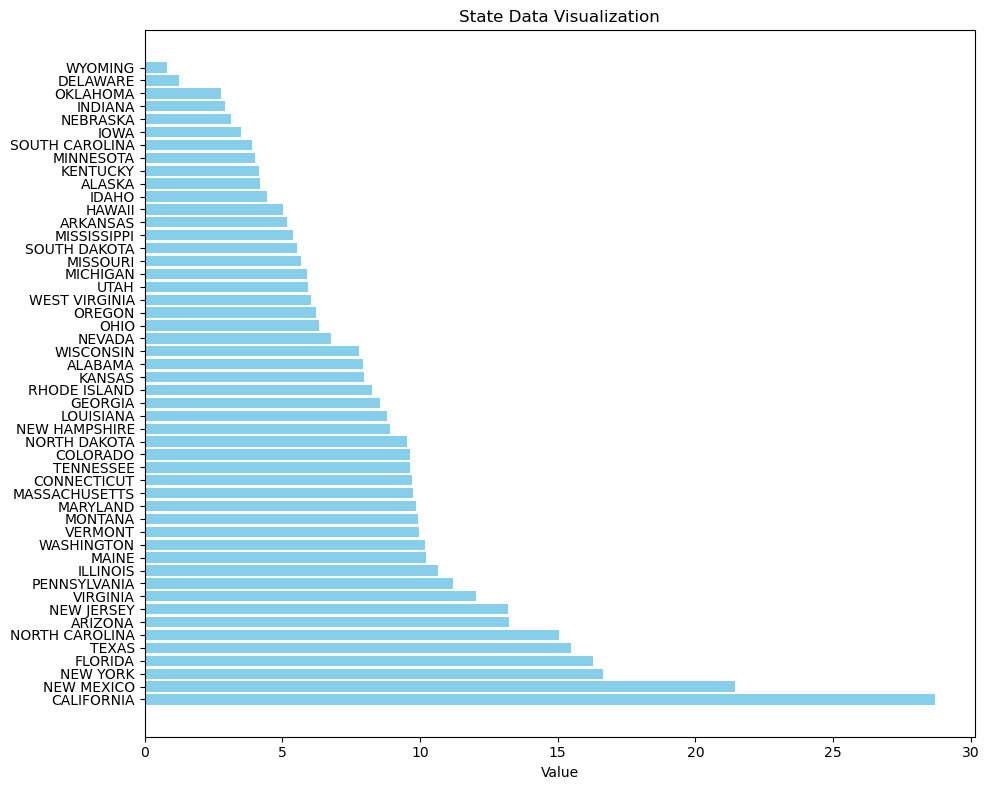

In [227]:
# Extracting states and their respective values
states = list(state_z_scores.keys())
values = list(state_z_scores.values())

# Plotting the bar graph
plt.figure(figsize=(10, 8))
plt.barh(states, values, color='skyblue')
plt.xlabel('Value')
plt.title('State Data Visualization')

# To make the y-axis labels more readable
plt.tight_layout()

# Show the plot
plt.show()